In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.utils as vutils
import torchvision.datasets as vdatasets
import torchvision.transforms as transforms


import numpy as np

from tqdm import tqdm

In [2]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [3]:
# Set constants and hyper parameters

# Data
root_folder = "./celeba"
batch_size = 128

# Image
img_size = 64
num_color_channels = 3

# Generator
latent_vector_size = 100
ngf = 64

# Discriminator
ndf = 64

# Optimizer
lr = 0.0002
beta1 = 0.5

# Training
epochs = 1

In [4]:
dataset = vdatasets.ImageFolder(
    root = root_folder,
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)


In [5]:
# Data Loader
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle=True
)

# This returns a list of size 2 = > [images_tensor, labels_tensor]


In [6]:
# Sanity checj with 1 batch

dl = next(iter(data_loader))
dl[0].shape, dl[1].shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

In [7]:
# Build Generator Network

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            # Input (100-> ngf*8)
            nn.ConvTranspose2d(
                in_channels = latent_vector_size,
                out_channels = ngf*8,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False
            ),
            
            nn.BatchNorm2d(ngf*8),
            
            # Inplace
            nn.ReLU(True),
            
            # ngf*8 -> ngf*4
            nn.ConvTranspose2d(
                in_channels = ngf*8,
                out_channels = ngf*4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            
            nn.BatchNorm2d(ngf*4),
            
            # Inplace
            nn.ReLU(True),
            
            # ngf*4 -> ngf*2
            nn.ConvTranspose2d(
                in_channels = ngf*4,
                out_channels = ngf*2,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            
            nn.BatchNorm2d(ngf*2),
            
            # Inplace
            nn.ReLU(True),
            
            # ngf*2 -> ngf
            nn.ConvTranspose2d(
                in_channels = ngf*2,
                out_channels = ngf,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            
            nn.BatchNorm2d(ngf),
            
            # Inplace
            nn.ReLU(True),
            
            
            # Output
            nn.ConvTranspose2d(
                in_channels = ngf,
                out_channels = num_color_channels,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            
            nn.Tanh()
        )
        
    def forward(self, X):
        return self.layers(X)

    
netG = Generator()
netG

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [8]:
# Build Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            
            # Input
            nn.Conv2d(
                in_channels = num_color_channels,
                out_channels = ndf,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            
            nn.LeakyReLU(0.2,inplace = True),
            
            
            # ndf -> ndf*2
            nn.Conv2d(
                in_channels = ndf,
                out_channels = ndf*2,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            
            # BatchNorm
            nn.BatchNorm2d(ndf*2),
            
            nn.LeakyReLU(0.2,inplace = True),
            
            # ndf*2 -> ndf*4
            nn.Conv2d(
                in_channels = ndf*2,
                out_channels = ndf*4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            
            # BatchNorm
            nn.BatchNorm2d(ndf*4),
            
            nn.LeakyReLU(0.2,inplace = True),
            
            
            # ndf4 -> ndf*8
            nn.Conv2d(
                in_channels = ndf*4,
                out_channels = ndf*8,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            
            # BatchNorm
            nn.BatchNorm2d(ndf*8),
            
            nn.LeakyReLU(0.2,inplace = True),
            
            
            # ndf*8 ->1
            nn.Conv2d(
                in_channels = ndf*8,
                out_channels = 1,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False
            ),
            
            nn.Sigmoid()
        )
    
    def forward(self, X):
        return self.layers(X)

netD = Discriminator()
netD

Discriminator(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [9]:
# Weights Init Helper function
def init_weights(m):
    class_name = m.__class__.__name__
    if class_name.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif class_name.find("BatchNorm") !=-1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# Initialize netD and netG with weights

netD = Discriminator().to(device)
init_weights(netD)

netG = Generator().to(device)
init_weights(netG)



In [11]:
# Initialize optimizers

optimizer_netD = optim.Adam(netD.parameters(),lr=lr, betas =(beta1,0.999))
optimizer_netG = optim.Adam(netG.parameters(), lr=lr, betas =(beta1, 0.999))

# Initialize Loss
criterion = nn.BCELoss()

# Random noise
fixed_noise = torch.randn(img_size, latent_vector_size,1,1, device = device)

real_image_label = 1
fake_image_label = 0

In [15]:
# Training Loop
img_list = []
iters = 0


generator_batch_loss = []
discriminator_batch_loss = []


for epoch in range(epochs):
    
    for i, batch in enumerate(data_loader, 0):
        
        # Discriminator Training
        # Train Discriinator on real_images
        
        real_images, _ = batch
        batch_size = real_images.shape[0]
        real_images = real_images.to(device)
        

        actual_labels = torch.full((batch_size,), real_image_label, device = device)
        
        netD.zero_grad()
        
        netD_prediction_real_images = netD(real_images).view(-1)
        
        loss1 = criterion(netD_prediction_real_images, actual_labels)
        
        D_x = netD_prediction_real_images.mean().item()

        
        loss1.backward()
        
        # Train Discriminator on Fake images
        actual_labels.fill_(fake_image_label)
        
        # Prepare noise of (128,100,1,1,)
        noise = torch.randn(batch_size, latent_vector_size, 1,1 , device = device)
        
        # Generate fake image
        fake_images = netG(noise)
        
        # Predict with D
        netD_prediction_fake_images = netD(fake_images.detach()).view(-1)
        
        loss2 = criterion(netD_prediction_fake_images, actual_labels)
        
        # Mean
        D_G_z1 = netD_prediction_fake_images.mean().item()
        
        loss2.backward()
        
        netD_total_loss = loss1+loss2
        
        # Gradient descent
        optimizer_netD.step()
        
        
        # Train Generator
        netG.zero_grad()
        
        # Important: Tell the discriminator which is classifying these images
        # that the provided fake images are actually real
        actual_labels.fill_(real_image_label)
        
        
        # So in the intial stages, discriminator will produce a big loss
        # as it was trained to detect fake images in the discriminator's training loop
        # but finds that these fake images were classified as real
        # This loss is the generator loss. 
        # The Generator will learn to minimize this loss by updating its weights
        # and starts producing more realistic images over a period of time
        netD_pedicted_fake_images_for_netG = netD(fake_images).view(-1)
        
        
        netG_total_loss = criterion(netD_pedicted_fake_images_for_netG, actual_labels)
        
        D_G_z2 = netD_pedicted_fake_images_for_netG.mean().item()

                
        netG_total_loss.backward()
        
        optimizer_netG.step()
        
        # Record the gen and discriminator total losses
        discriminator_batch_loss.append(netD_total_loss.item())
        generator_batch_loss.append(netG_total_loss.item())
        
        # Output losses after every batch
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(data_loader),
                     netD_total_loss.item(), netG_total_loss.item(), D_x, D_G_z1, D_G_z2))
        
        
        
        # Record how the generator is progressing by capturing the generated image grid
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        

[0/1][0/1583]	Loss_D: 0.4009	Loss_G: 5.4137	D(x): 0.0775	D(G(z)): 0.3234 / 5.4137
[0/1][50/1583]	Loss_D: 0.0502	Loss_G: 5.9280	D(x): 0.0087	D(G(z)): 0.0415 / 5.9280
[0/1][100/1583]	Loss_D: 0.9835	Loss_G: 7.3600	D(x): 0.9817	D(G(z)): 0.0018 / 7.3600
[0/1][150/1583]	Loss_D: 0.7979	Loss_G: 2.7056	D(x): 0.4537	D(G(z)): 0.3442 / 2.7056
[0/1][200/1583]	Loss_D: 0.7955	Loss_G: 5.2379	D(x): 0.1912	D(G(z)): 0.6043 / 5.2379
[0/1][250/1583]	Loss_D: 0.5878	Loss_G: 3.7329	D(x): 0.2501	D(G(z)): 0.3377 / 3.7329
[0/1][300/1583]	Loss_D: 0.6055	Loss_G: 3.2602	D(x): 0.1824	D(G(z)): 0.4232 / 3.2602
[0/1][350/1583]	Loss_D: 0.7245	Loss_G: 1.5853	D(x): 0.6631	D(G(z)): 0.0614 / 1.5853
[0/1][400/1583]	Loss_D: 0.9946	Loss_G: 1.5367	D(x): 0.8903	D(G(z)): 0.1043 / 1.5367
[0/1][450/1583]	Loss_D: 0.9916	Loss_G: 1.9785	D(x): 0.9585	D(G(z)): 0.0331 / 1.9785
[0/1][500/1583]	Loss_D: 0.5299	Loss_G: 3.2914	D(x): 0.4801	D(G(z)): 0.0498 / 3.2914
[0/1][550/1583]	Loss_D: 1.3873	Loss_G: 2.4096	D(x): 1.3768	D(G(z)): 0.0105 / 2.

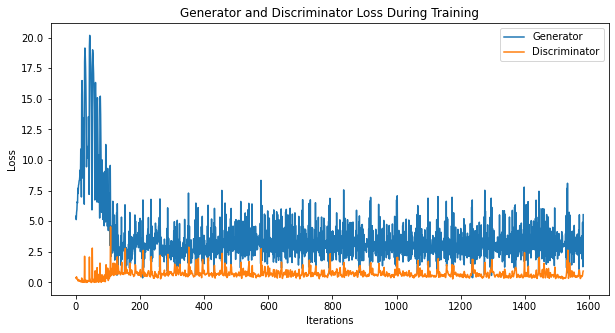

In [19]:
# Plot the Generator and Discriminator Losses
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(generator_batch_loss, label ="Generator")
plt.plot(discriminator_batch_loss, label ="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss During Training")
plt.show()



In [20]:
len(img_list)

5

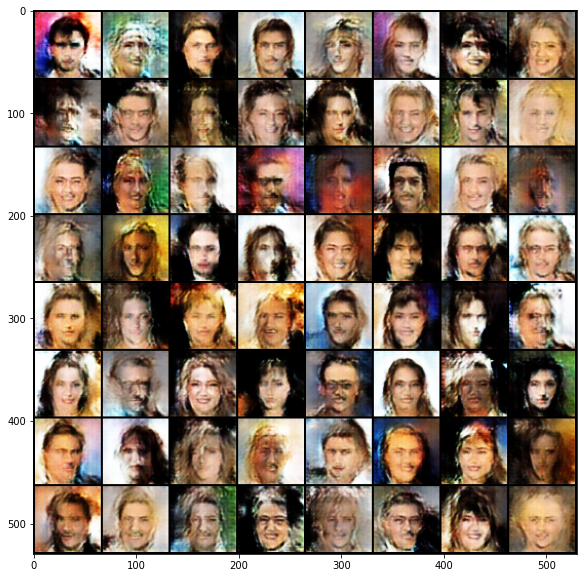

In [23]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(10,10))
ims = [ [plt.imshow(np.transpose(image, (1,2,0)),animated=True)]for image in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


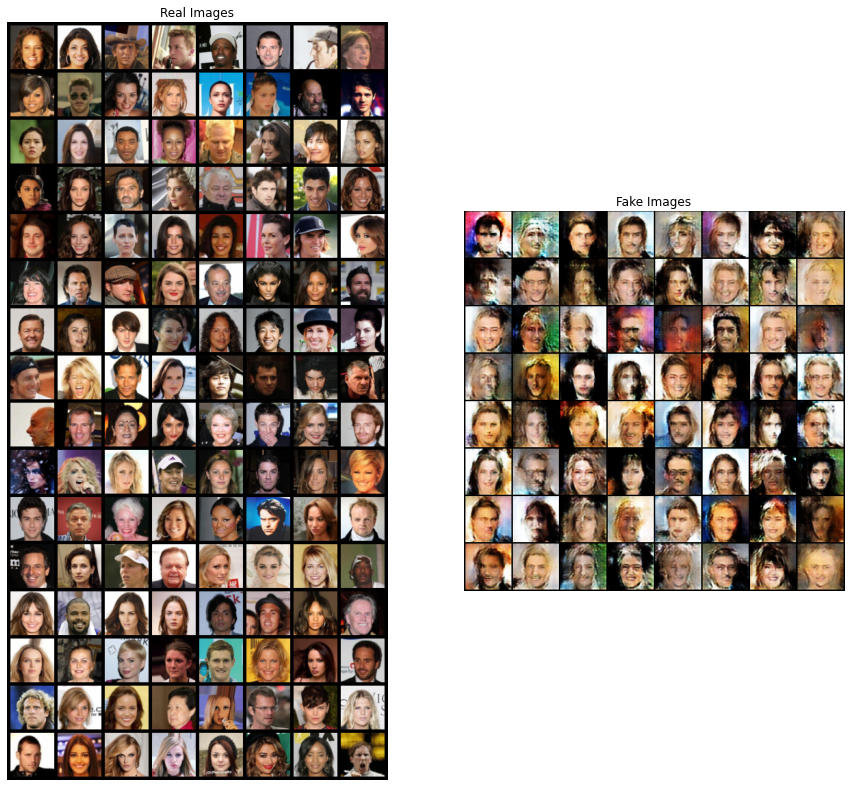

In [29]:
# Display Real Images on the grid
batch = next(iter(data_loader))
real_images = batch[0]

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")

# Prepare the numpy array
# Make image grid
img_grid = vutils.make_grid(real_images, padding=5, normalize=True).cpu()
img_numpy = np.transpose(img_grid, (1,2,0))
plt.imshow(img_numpy)


# Display Generated Images on the grid
plt.subplot(1,2,2)
plt.title("Fake Images")
plt.axis("off")
fk_img_grid = img_list[-1]
fk_img_numpy = np.transpose(fk_img_grid, (1,2,0))
plt.imshow(fk_img_numpy)

